# RoBERTa Text Regression — Robust Trainer (Auto-Resume + Safe Checkpoints)

This notebook is a clean, **from-scratch** training pipeline for text regression using
Hugging Face `Trainer`. It addresses:
- Frequent & reliable **checkpointing** (by steps **and** at each epoch end)
- **Auto-resume** from the latest checkpoint
- Single **progress bar** (no duplicate bars under DDP)
- **Version-safe** RMSE metric (handles sklearn without `squared=False`)
- Clean separation of config so you can change paths and hyperparameters quickly

In [7]:
# --- Environment reset: kill any accidental distributed context ---
import os, sys, platform, torch

# Silence huggingface/tokenizers fork warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# If something previously initialized torch.distributed, tear it down
if torch.distributed.is_available() and torch.distributed.is_initialized():
    try:
        torch.distributed.destroy_process_group()
    except Exception:
        pass

# Strip env vars that make HF/Accelerate think it's distributed
for var in ["RANK", "WORLD_SIZE", "LOCAL_RANK", "SLURM_PROCID",
            "SLURM_NTASKS", "OMPI_COMM_WORLD_SIZE", "ACCELERATE_USE_DEEPSPEED"]:
    os.environ.pop(var, None)

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Torch:", torch.__version__, "| CUDA avail:", torch.cuda.is_available(),
      "| GPUs:", torch.cuda.device_count())
import transformers, sklearn
print("Transformers:", transformers.__version__, "| sklearn:", sklearn.__version__)

# Small perf nicety
torch.backends.cudnn.benchmark = True


Python: 3.10.12
Platform: Linux-5.15.0-157-generic-x86_64-with-glibc2.35
Torch: 2.3.1+cu118 | CUDA avail: True | GPUs: 8
Transformers: 4.57.1 | sklearn: 1.7.1


In [66]:
%pip install duckdb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
from pathlib import Path
import duckdb

def make_single_category_splits(infile, category, outdir):
    infile = Path(infile).as_posix()
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
    db = duckdb.connect(database=":memory:")

    rel = db.sql("SELECT * FROM read_parquet(?) WHERE category_1 = ? AND pctl IS NOT NULL",
                 params=[infile, category])
    rel.create_view("data", replace=True)

    db.sql("""
        CREATE TABLE d AS
        SELECT *, ntile(10) OVER (ORDER BY pctl) AS pctl_decile
        FROM data
    """)
    db.sql("""
        CREATE TABLE r AS
        SELECT *, 
               row_number() OVER (PARTITION BY pctl_decile ORDER BY hash(display_id)) AS rn,
               count(*)    OVER (PARTITION BY pctl_decile)                            AS cnt
        FROM d
    """)
    db.sql("""
        CREATE VIEW split AS
        SELECT display_id, title, category_1, size_bin, upload_period, vpd, pctl,
               CASE WHEN rn <= 0.70*cnt THEN 'train'
                    WHEN rn <= 0.85*cnt THEN 'val'
                    ELSE 'test' END AS split
        FROM r
    """)

    db.sql(f"COPY (SELECT * FROM split WHERE split='train') TO '{(outdir/'train.parquet').as_posix()}' (FORMAT PARQUET)")
    db.sql(f"COPY (SELECT * FROM split WHERE split='val')   TO '{(outdir/'val.parquet').as_posix()}'   (FORMAT PARQUET)")
    db.sql(f"COPY (SELECT * FROM split WHERE split='test')  TO '{(outdir/'test.parquet').as_posix()}'  (FORMAT PARQUET)")

    print(db.sql("SELECT split, COUNT(*) n, MIN(pctl) min_pctl, MAX(pctl) max_pctl FROM split GROUP BY 1 ORDER BY 1").df())
    return outdir

In [ ]:
# creates 70/15/15 dataset per category that includes only selecting large channels only in dataset

from pathlib import Path
import duckdb

def make_category_splits_large_channels(
    infile: str = "labeled_2019_english_reranked.parquet",
    outdir: str = "splits_by_category_large",
    min_size_bin: int = 6
):
    """
    Create train/val/test splits by category for channels with size_bin >= min_size_bin.
    
    Each category gets its own subfolder with train.parquet, val.parquet, test.parquet.
    Split is 70/15/15, stratified by pctl deciles within each category.
    
    Args:
        infile: Path to the labeled parquet file
        outdir: Base directory for output splits
        min_size_bin: Minimum channel size bin to include (default 6)
    """
    infile = Path(infile).as_posix()
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    
    db = duckdb.connect(database=":memory:")
    
    # Load data filtered by size_bin
    db.sql(f"""
        CREATE OR REPLACE VIEW data AS
        SELECT *
        FROM read_parquet('{infile}')
        WHERE size_bin >= {min_size_bin}
          AND pctl IS NOT NULL
          AND category_1 IS NOT NULL
          AND category_1 <> 'Unknown';
    """)
    
    # Get list of categories
    categories = db.sql("""
        SELECT DISTINCT category_1 
        FROM data 
        ORDER BY category_1
    """).df()['category_1'].tolist()
    
    print(f"Processing {len(categories)} categories with size_bin >= {min_size_bin}...")
    print(f"Categories: {', '.join(categories)}\n")
    
    for category in categories:
        cat_dir = outdir / category.replace(' ', '_').replace('&', 'and').lower()
        cat_dir.mkdir(parents=True, exist_ok=True)
        
        # Filter by category and create deciles
        db.sql(f"""
            CREATE OR REPLACE TABLE cat_data AS
            SELECT *,
                   ntile(10) OVER (ORDER BY pctl) AS pctl_decile
            FROM data
            WHERE category_1 = '{category}';
        """)
        
        # assign train/val/test within each decile
        db.sql("""
            CREATE OR REPLACE TABLE cat_ranked AS
            SELECT *,
                   row_number() OVER (PARTITION BY pctl_decile ORDER BY hash(display_id)) AS rn,
                   count(*)     OVER (PARTITION BY pctl_decile) AS cnt
            FROM cat_data;
        """)
        
        db.sql("""
            CREATE OR REPLACE VIEW cat_split AS
            SELECT
                display_id, title, title_min, title_tfidf,
                category_1, size_bin, upload_period, vpd, pctl, label,
                CASE
                    WHEN rn <= 0.70*cnt THEN 'train'
                    WHEN rn <= 0.85*cnt THEN 'val'
                    ELSE 'test'
                END AS split
            FROM cat_ranked;
        """)
        
        # write splits for this category
        train_path = (cat_dir / "train.parquet").as_posix()
        val_path = (cat_dir / "val.parquet").as_posix()
        test_path = (cat_dir / "test.parquet").as_posix()
        
        db.sql(f"COPY (SELECT * FROM cat_split WHERE split='train') TO '{train_path}' (FORMAT PARQUET);")
        db.sql(f"COPY (SELECT * FROM cat_split WHERE split='val')   TO '{val_path}'   (FORMAT PARQUET);")
        db.sql(f"COPY (SELECT * FROM cat_split WHERE split='test')  TO '{test_path}'  (FORMAT PARQUET);")
        
        # summary stats
        stats = db.sql("""
            SELECT 
                split, 
                COUNT(*) AS n,
                MIN(pctl) AS min_pctl,
                MAX(pctl) AS max_pctl,
                AVG(label::FLOAT) AS label_rate
            FROM cat_split
            GROUP BY split
            ORDER BY split
        """).df()
        
        print(f"{category}:")
        print(stats.to_string(index=False))
        print()
    
    print(f"\n✓ Splits written to: {outdir.resolve()}")
    return outdir


if __name__ == "__main__":
    make_category_splits_large_channels(
        infile="labeled_2019_english_reranked.parquet",
        outdir="splits_by_category_large",
        min_size_bin=6
    )

Processing 10 categories with size_bin >= 6...
Categories: Autos & Vehicles, Education, Entertainment, Film & Animation, Gaming, Howto & Style, News & Politics, People & Blogs, Science & Technology, Sports

Autos & Vehicles:
split     n  min_pctl  max_pctl  label_rate
 test  7490       0.0  0.999867    0.200267
train 34920       0.0  1.000000    0.200086
  val  7480       0.0  1.000000    0.200134

Education:
split      n  min_pctl  max_pctl  label_rate
 test  24780       0.0       1.0    0.200121
train 115628       0.0       1.0    0.200073
  val  24780       0.0       1.0    0.200040



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Entertainment:
split      n  min_pctl  max_pctl  label_rate
 test 109140       0.0  0.999898    0.200009
train 509316       0.0  1.000000    0.200027
  val 109140       0.0  1.000000    0.200018

Film & Animation:
split     n  min_pctl  max_pctl  label_rate
 test 12199       0.0  0.999872    0.199934
train 56880       0.0  1.000000    0.200105
  val 12190       0.0  0.999732    0.200000

Gaming:
split      n  min_pctl  max_pctl  label_rate
 test  72990       0.0       1.0    0.200055
train 340572       0.0       1.0    0.200028
  val  72980       0.0       1.0    0.200041



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Howto & Style:
split      n  min_pctl  max_pctl  label_rate
 test  23420       0.0  1.000000    0.200171
train 109265       0.0  1.000000    0.200009
  val  23410       0.0  0.999936    0.200043

News & Politics:
split      n  min_pctl  max_pctl  label_rate
 test 140560       0.0       1.0    0.200007
train 655920       0.0       1.0    0.200024
  val 140551       0.0       1.0    0.200013

People & Blogs:
split      n  min_pctl  max_pctl  label_rate
 test  27610       0.0       1.0    0.200181
train 128820       0.0       1.0    0.200070
  val  27605       0.0       1.0    0.200000

Science & Technology:
split     n  min_pctl  max_pctl  label_rate
 test 12294       0.0  1.000000    0.199935
train 57350       0.0  1.000000    0.200122
  val 12290       0.0  0.999912    0.200000

Sports:
split      n  min_pctl  max_pctl  label_rate
 test  29610       0.0       1.0    0.200068
train 138170       0.0       1.0    0.200087
  val  29610       0.0       1.0    0.200101


✓ Splits written to:

In [ ]:
# only for 1 quarter time period
from pathlib import Path
import duckdb

def make_entertainment_q1_split(
    infile: str = "labeled_2019_english_reranked.parquet",
    outdir: str = "entertainment_q2",
    category: str = "Entertainment",
    time_periods: list = "2019-03"  # e.g., ["2019-01", "2019-02", "2019-03"] or ["2019Q1"]
):
    """
    Create train/val/test splits for a single category from specific time periods.
    
    Args:
        infile: Path to the labeled parquet file
        outdir: Output directory for splits
        category: Category name (default "Entertainment")
        time_periods: List of upload_period values to include. 
                     If None, uses first quarter: ["2019-01", "2019-02", "2019-03", "2019Q1"]
    """
    infile = Path(infile).as_posix()
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    
    if time_periods is None:
        time_periods = ["2019-01", "2019-02", "2019-03", "2019Q1"]
    
    db = duckdb.connect(database=":memory:")
    
    # filter for time periods
    period_filter = " OR ".join([f"upload_period = '{p}'" for p in time_periods])
    
    # load filtered data
    db.sql(f"""
        CREATE OR REPLACE VIEW data AS
        SELECT *
        FROM read_parquet('{infile}')
        WHERE category_1 = '{category}'
          AND ({period_filter})
          AND pctl IS NOT NULL;
    """)
    
    # check how much data we have
    count_df = db.sql("SELECT COUNT(*) AS n FROM data").df()
    n_rows = count_df.iloc[0, 0]
    
    if n_rows == 0:
        print(f"⚠ No data found for {category} in periods: {time_periods}")
        return None
    
    print(f"Found {n_rows:,} videos for {category} in {time_periods}")
    
    # Show breakdown by upload_period and size_bin
    print("\nBreakdown by upload_period:")
    print(db.sql("SELECT upload_period, COUNT(*) n FROM data GROUP BY 1 ORDER BY 1").df())
    
    print("\nBreakdown by size_bin:")
    print(db.sql("SELECT size_bin, COUNT(*) n FROM data GROUP BY 1 ORDER BY 1").df())
    
    # Create deciles for stratification
    db.sql("""
        CREATE OR REPLACE TABLE with_decile AS
        SELECT *,
               ntile(10) OVER (ORDER BY pctl) AS pctl_decile
        FROM data;
    """)
    
    # Assign train/val/test within each decile (70/15/15)
    db.sql("""
        CREATE OR REPLACE TABLE ranked AS
        SELECT *,
               row_number() OVER (PARTITION BY pctl_decile ORDER BY hash(display_id)) AS rn,
               count(*)     OVER (PARTITION BY pctl_decile) AS cnt
        FROM with_decile;
    """)
    
    db.sql("""
        CREATE OR REPLACE VIEW split AS
        SELECT
            display_id, title, title_min, title_tfidf,
            category_1, size_bin, upload_period, vpd, pctl, label,
            CASE
                WHEN rn <= 0.70*cnt THEN 'train'
                WHEN rn <= 0.85*cnt THEN 'val'
                ELSE 'test'
            END AS split
        FROM ranked;
    """)
    
    # write split files
    train_path = (outdir / "train.parquet").as_posix()
    val_path = (outdir / "val.parquet").as_posix()
    test_path = (outdir / "test.parquet").as_posix()
    
    db.sql(f"COPY (SELECT * FROM split WHERE split='train') TO '{train_path}' (FORMAT PARQUET);")
    db.sql(f"COPY (SELECT * FROM split WHERE split='val')   TO '{val_path}'   (FORMAT PARQUET);")
    db.sql(f"COPY (SELECT * FROM split WHERE split='test')  TO '{test_path}'  (FORMAT PARQUET);")
    
    # summary statistics
    print("\nSplit summary:")
    stats = db.sql("""
        SELECT 
            split, 
            COUNT(*) AS n,
            MIN(pctl) AS min_pctl,
            MAX(pctl) AS max_pctl,
            AVG(label::FLOAT) AS label_rate
        FROM split
        GROUP BY split
        ORDER BY split
    """).df()
    print(stats.to_string(index=False))
    
    print(f"\n✓ Splits written to: {outdir.resolve()}")
    return outdir


make_entertainment_q1_split(
    infile="labeled_2019_english_reranked.parquet",
    outdir="entertainment_q1"
)

make_entertainment_q1_split(
    infile="labeled_2019_english_reranked.parquet",
    outdir="entertainment_jan",
    time_periods=["2019-01"]
)

make_entertainment_q1_split(
    infile="labeled_2019_english_reranked.parquet",
    outdir="entertainment_jan_feb",
    time_periods=["2019-01", "2019-02"]
)

make_entertainment_q1_split(
    infile="labeled_2019_english_reranked.parquet",
    outdir="gaming_q1",
    category="Gaming",
    time_periods=["2019-01", "2019-02", "2019-03", "2019Q1"]
)

⚠ No data found for Entertainment in periods: 2019-03
Found 135,259 videos for Entertainment in ['2019-01']

Breakdown by upload_period:
  upload_period       n
0       2019-01  135259

Breakdown by size_bin:
   size_bin      n
0         0  11751
1         1   7260
2         2  10197
3         3   9784
4         4   9652
5         5  13057
6         6  15908
7         7  16924
8         8  19613
9         9  21113

Split summary:
split     n  min_pctl  max_pctl  label_rate
 test 20290       0.0  0.999902    0.200000
train 94679       0.0  1.000000    0.200044
  val 20290       0.0  0.999896    0.200000

✓ Splits written to: /home/jovyan/yt titles/entertainment_jan
Found 253,109 videos for Entertainment in ['2019-01', '2019-02']

Breakdown by upload_period:
  upload_period       n
0       2019-01  135259
1       2019-02  117850

Breakdown by size_bin:
   size_bin      n
0         0  18660
1         1  14988
2         2  18087
3         3  17281
4         4  17048
5         5  23701
6   

PosixPath('gaming_q1')

In [9]:
def describe_single_category(outdir):
    outdir = Path(outdir)
    db = duckdb.connect(database=":memory:")
    db.sql(f"""
      CREATE VIEW data AS
      SELECT *,'train' split FROM read_parquet('{(outdir/'train.parquet').as_posix()}')
      UNION ALL SELECT *,'val'   FROM read_parquet('{(outdir/'val.parquet').as_posix()}')
      UNION ALL SELECT *,'test'  FROM read_parquet('{(outdir/'test.parquet').as_posix()}')
    """)
    print(db.sql("SELECT split, COUNT(*) n FROM data GROUP BY 1 ORDER BY 1").df())
    print(db.sql("SELECT MIN(pctl) min, MEDIAN(pctl) med, MAX(pctl) max, AVG(pctl) mean FROM data").df())
    print(db.sql("SELECT COALESCE(CAST(size_bin AS INT),-1) size_bin, COUNT(*) n FROM data GROUP BY 1 ORDER BY 1").df())
    print(db.sql("SELECT upload_period, COUNT(*) n FROM data GROUP BY 1 ORDER BY 1").df())

In [10]:
# CREATES DATASETS FOR 1 GIVEN CATEGORY ALL CHANNEL SIZES
infile = "labeled_2019_english_reranked.parquet"
category = "Gaming"

outdir = f"{category.replace(' ','_').lower()}"

make_single_category_splits(infile, category, outdir)
describe_single_category(outdir)

   split        n  min_pctl  max_pctl
0   test   233420       0.0       1.0
1  train  1089274       0.0       1.0
2    val   233420       0.0       1.0
   split        n
0   test   233420
1  train  1089274
2    val   233420
   min  med  max      mean
0  0.0  0.5  1.0  0.499968
   size_bin       n
0         0  188198
1         1  178769
2         2  170728
3         3  166418
4         4  202237
5         5  163222
6         6  176704
7         7  132584
8         8  112409
9         9   64845
   upload_period       n
0        2019-01  151177
1        2019-02  142643
2        2019-03  161568
3        2019-04  146908
4        2019-05  156820
5        2019-06  150287
6        2019-07  149969
7        2019-08  153009
8        2019-09  148103
9         2019Q1   61497
10        2019Q2   59154
11        2019Q3   63277
12        2019Q4   11702


In [40]:
category = 'education'
category_dir = f'splits_by_category_large/{category}'
print(category_dir)

splits_by_category_large/news_and_politics


In [70]:
%pip install torch
%pip install sklearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package i

In [6]:
pip install -U "transformers>=4.44" "accelerate>=0.33" "datasets>=2.19" "evaluate" "tokenizers>=0.19"

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [71]:
import transformers, torch
print("transformers:", transformers.__version__)
print("torch:", torch.__version__)

transformers: 4.57.1
torch: 2.3.1+cu118


In [ ]:

from dataclasses import replace
import math, os
from pathlib import Path

# data
DATA_DIR = Path('entertainment_jan_feb')     # <-- EDIT to your splits folder
TRAIN_F = DATA_DIR / "train.parquet"
VAL_F   = DATA_DIR / "val.parquet"
TEST_F  = DATA_DIR / "test.parquet"
TEXT_COL = "title"                             # text column
LABEL_COL = "pctl"                             # regression target

# model & tokenization
MODEL_NAME = "roberta-base"
MAX_LEN = 32

# training sizes
BATCH = 160
GRAD_ACCUM = 1
EPOCHS = 20
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.05

# output directory 
OUT_DIR = Path(os.path.abspath("./runs/roberta_entertainment_jan_feb"))
OUT_DIR.mkdir(parents=True, exist_ok=True)

# reproducibility
from transformers import set_seed
SEED = 1337
set_seed(SEED)

print("Output dir:", OUT_DIR)

Output dir: /home/jovyan/yt titles/runs/roberta_entertainment_jan_feb


In [ ]:
# load
import pandas as pd, numpy as np
from pathlib import Path

def _require(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return path

train_df = pd.read_parquet(_require(TRAIN_F))
val_df   = pd.read_parquet(_require(VAL_F))
test_df  = pd.read_parquet(_require(TEST_F))

# using title text only
train_texts = train_df[TEXT_COL].astype(str).tolist()
val_texts   = val_df[TEXT_COL].astype(str).tolist()
test_texts  = test_df[TEXT_COL].astype(str).tolist()

y_train = train_df[LABEL_COL].astype("float32").to_numpy()
y_val   = val_df[LABEL_COL].astype("float32").to_numpy()
y_test  = test_df[LABEL_COL].astype("float32").to_numpy()

print("Train/Val/Test sizes:", len(train_texts), len(val_texts), len(test_texts))

Train/Val/Test sizes: 177170 37969 37970


In [ ]:

from transformers import AutoTokenizer, DataCollatorWithPadding
import torch, numpy as np

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
collator = DataCollatorWithPadding(tok, pad_to_multiple_of=8)

def encode(texts):
    return tok(texts, truncation=True, max_length=MAX_LEN)

enc_train = encode(train_texts)
enc_val   = encode(val_texts)
enc_test  = encode(test_texts)

class TorchDS(torch.utils.data.Dataset):
    def __init__(self, enc, y):
        self.enc = enc
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(self.y[i], dtype=torch.float32)
        return item

ds_train = TorchDS(enc_train, y_train)
ds_val   = TorchDS(enc_val,   y_val)
ds_test  = TorchDS(enc_test,  y_test)

print("Example item keys:", list(ds_train[0].keys()))

Example item keys: ['input_ids', 'attention_mask', 'labels']


In [99]:
# --- Model: single process, all GPUs via DataParallel ---
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
model.config.problem_type = "regression"
model.to(device)

ngpu = torch.cuda.device_count()
if ngpu > 1:
    print(f"Using DataParallel on {ngpu} GPUs")
    model = torch.nn.DataParallel(model)  # splits each batch across GPUs
else:
    print("Using a single GPU or CPU")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using DataParallel on 8 GPUs


In [100]:
import inspect, sys
import transformers as tfm
print("Transformers version:", tfm.__version__)

# Verify we’re using HF’s TrainingArguments
from transformers import TrainingArguments
print("TrainingArguments comes from:", TrainingArguments.__module__)
print("Source file:", inspect.getsourcefile(TrainingArguments))
print("Is dataclass:", hasattr(TrainingArguments, "__dataclass_fields__"))

# Make sure the symbol wasn’t overwritten earlier
print("TrainingArguments object repr:", TrainingArguments)

# 2) Minimal instantiation test (should run without error)
from transformers.training_args import IntervalStrategy
_try = TrainingArguments(output_dir="out", evaluation_strategy="steps")
print("eval strategy value:", _try.evaluation_strategy)


Transformers version: 4.57.1
TrainingArguments comes from: transformers.training_args
Source file: /home/jovyan/.local/lib/python3.10/site-packages/transformers/training_args.py
Is dataclass: True
TrainingArguments object repr: <class 'transformers.training_args.TrainingArguments'>


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [101]:
import transformers as tfm
HFTrainingArguments = tfm.TrainingArguments

In [ ]:
# training arguments
from transformers import TrainingArguments
import math, torch

steps_per_epoch = max(1, math.ceil(len(ds_train) / (BATCH * GRAD_ACCUM)))
SAFE_SAVE_STEPS = max(50, steps_per_epoch // 4)
LOG_STEPS       = max(5, SAFE_SAVE_STEPS // 5)

use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
use_fp16 = torch.cuda.is_available() and not use_bf16

args = HFTrainingArguments(
    output_dir=str(OUT_DIR),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,

    eval_strategy="steps",
    eval_steps=SAFE_SAVE_STEPS,
    save_strategy="steps",
    save_steps=SAFE_SAVE_STEPS,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="spearman",
    greater_is_better=True,

    logging_strategy="steps",
    logging_steps=LOG_STEPS,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    dataloader_persistent_workers=True,
    group_by_length=True,
    report_to="none",
    disable_tqdm=False,

    bf16=use_bf16,
    fp16=use_fp16,

    # Prevent Trainer from dropping `input_ids`/`attention_mask` with DataParallel
    remove_unused_columns=False,
    label_names=["labels"],
)
print(f"steps/epoch={steps_per_epoch} | save/eval every {SAFE_SAVE_STEPS} steps")


steps/epoch=1108 | save/eval every 277 steps


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import spearmanr
from transformers import TrainerCallback

def compute_metrics_reg(eval_pred):
    preds  = eval_pred.predictions.squeeze(-1)
    labels = eval_pred.label_ids.astype(np.float32)

    mae = float(mean_absolute_error(labels, preds))
    mse = float(mean_squared_error(labels, preds))
    mape = mean_absolute_percentage_error(labels, preds)
    rmse = np.sqrt(mse)
    print(preds)
    print(labels)
    r2 = r2_score(labels, preds)
    sp = spearmanr(labels, preds).correlation
    if np.isnan(sp):
        sp = 0.0
    return {"mae": float(mae), "mse": mse, "rmse": rmse,  "mape": mape, 
            "spearman": float(sp), "r2": float(r2)}

# Single progress bar on main process only
from tqdm.auto import tqdm

class TqdmProgressCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        is_main = getattr(state, "is_local_process_zero", True)
        if not is_main:
            self.pbar = None
            return
        self.pbar = tqdm(total=state.max_steps, desc="Training", leave=True)

    def on_step_end(self, args, state, control, **kwargs):
        if self.pbar is not None:
            self.pbar.update(1)
        return control

    def on_log(self, args, state, control, logs=None, **kwargs):
        if self.pbar is not None and logs:
            pf = {}
            if "loss" in logs: pf["loss"] = f"{logs['loss']:.4f}"
            if "learning_rate" in logs: pf["lr"] = f"{logs['learning_rate']:.2e}"
            if pf: self.pbar.set_postfix(pf)

    def on_train_end(self, *a, **k):
        if self.pbar is not None:
            self.pbar.close()

# Force a save at each epoch end 
class EpochEndSaver(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        control.should_save = True

In [ ]:
# trainer


from pathlib import Path
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics_reg, 
    callbacks=[TqdmProgressCallback(), EpochEndSaver(),
               EarlyStoppingCallback(early_stopping_patience=3)],
)

# resume from latest checkpoint if present
ckpts = sorted(Path(args.output_dir).glob("checkpoint-*"),
               key=lambda p: int(p.name.split("-")[-1]) if "-" in p.name else -1)
resume = str(ckpts[-1]) if ckpts else None
print("Resuming from:", resume or "scratch")

trainer.train(resume_from_checkpoint=resume)

print("Val:", trainer.evaluate(eval_dataset=ds_val))
print("Test:", trainer.evaluate(eval_dataset=ds_test))

EXPORT_DIR = Path("./model_export/roberta_entertainment_jan_feb_model")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
trainer.save_model(EXPORT_DIR)
tok.save_pretrained(EXPORT_DIR)
print("Saved export to:", EXPORT_DIR.resolve())


SyntaxError: invalid syntax (880155970.py, line 4)

In [ ]:
# Trainer (auto-resume)
trainer.train(resume_from_checkpoint=resume)

In [ ]:
# evaluate and save final model
print("Val:", trainer.evaluate(eval_dataset=ds_val))
print("Test:", trainer.evaluate(eval_dataset=ds_test))

EXPORT_DIR = Path("./model_export/roberta_entertainment_jan_feb_model")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
trainer.save_model(EXPORT_DIR)        # saves model + config
tok.save_pretrained(EXPORT_DIR)       # saves tokenizer
print("Saved export to:", EXPORT_DIR.resolve())

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Val: {'eval_loss': 0.04482445865869522, 'eval_mae': 0.169075608253479, 'eval_rmse': 0.21171262281778816, 'eval_spearman': 0.6767311092582236, 'eval_runtime': 9.921, 'eval_samples_per_second': 3827.122, 'eval_steps_per_second': 3.024, 'epoch': 20.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test: {'eval_loss': 0.04482154920697212, 'eval_mae': 0.16907581686973572, 'eval_rmse': 0.21171268440369634, 'eval_spearman': 0.6767308390051311, 'eval_runtime': 10.163, 'eval_samples_per_second': 3735.999, 'eval_steps_per_second': 2.952, 'epoch': 20.0}
Saved export to: /home/jovyan/yt titles/model_export/roberta_entertainment_jan_feb_model


In [137]:
pred = trainer.predict(ds_test)
print("Test", compute_metrics_reg(pred))

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[0.7441406  0.2434082  0.27661133 ... 0.3876953  0.05230713 0.08319092]
[0.93129593 0.26404852 0.3658387  ... 0.04653458 0.00486498 0.02510638]
Test {'mae': 0.16858252882957458, 'mse': 0.044544875621795654, 'rmse': 0.21105656971957934, 'mape': 861988716544.0, 'spearman': 0.6807886792788957, 'r2': 0.4664198160171509}


In [38]:
import zipfile

zip_path = "model_export/roberta_entertainment_jan_feb_model.zip"

extract_dir = os.path.splitext(zip_path)[0]  # same name as zip without .zip
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✓ Extracted")

FileNotFoundError: [Errno 2] No such file or directory: 'model_export/roberta_entertainment_jan_feb_model.zip'

In [ ]:
# load from checkpoint ,
import os, contextlib, torch, numpy as np
from torch.utils.data import DataLoader
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)

#  path
MODEL_DIR  = "model_export/roberta_entertainment_jan_feb_model"  # folder with your weights file
STATE_PATH = os.path.join(MODEL_DIR, "model.safetensors")        # or "pytorch_model.bin"
BASE_CKPT  = "roberta-base"                                      # the exact base you fine-tuned

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_CKPT, use_fast=True)

# build model exactly like training
config = AutoConfig.from_pretrained(BASE_CKPT)
config.num_labels = 1
config.problem_type = "regression"
model = AutoModelForSequenceClassification.from_config(config)

# fix 'module.' prefix from parallezation
if STATE_PATH.endswith(".safetensors"):
    from safetensors.torch import load_file
    sd = load_file(STATE_PATH, device="cpu")
else:
    sd = torch.load(STATE_PATH, map_location="cpu")

if any(k.startswith("module.") for k in sd.keys()):
    sd = {k.replace("module.", "", 1): v for k, v in sd.items()}

missing, unexpected = model.load_state_dict(sd, strict=True)
print(f"✓ Loaded weights | missing={len(missing)} unexpected={len(unexpected)}")

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()




✓ Loaded weights | missing=0 unexpected=0


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [195]:
## Compute metrics with loaded model

# Get data
test_df = pd.read_parquet("news_&_politics/test.parquet")
texts = test_df["title"].tolist()
y_true = test_df["pctl"].values

print(f"Test set size: {len(texts):,}")

# Predict in BATCHES
@torch.inference_mode()
def predict(texts, batch_size=128):
    """Predict in batches to avoid OOM."""
    device = next(model.parameters()).device
    all_preds = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        enc = tokenizer(
            batch_texts, 
            truncation=True, 
            max_length=96,
            return_tensors="pt", 
            padding=True
        )
        
        # Move to device
        enc = {k: v.to(device) for k, v in enc.items()}
        
        # Forward pass
        outputs = model(**enc)
        batch_preds = outputs.logits.squeeze(-1).cpu().numpy()
        
        # Handle single prediction (scalar vs array)
        if isinstance(batch_preds, (float, np.floating)):
            batch_preds = [batch_preds]
        
        all_preds.extend(batch_preds)
    
    return np.array(all_preds)

print("Generating predictions...")
y_pred = predict(texts, batch_size=128)

print(f"✓ Predictions shape: {y_pred.shape}")
print(f"  y_true shape: {y_true.shape}")

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
spearman = spearmanr(y_true, y_pred).correlation
r2 = r2_score(y_true, y_pred)

print(f"\nTest Set Performance:")
print(f"  MAE:      {mae:.4f}")
print(f"  MSE:     {mse:.4f}")
print(f"  RMSE:     {rmse:.4f}")
print(f"  Spearman: {spearman:.4f}")
print(f" MAPE: {mape_nonzero:4f}")
print(f" r2: {r2:4f}")


Test set size: 242,000
Generating predictions...
✓ Predictions shape: (242000,)
  y_true shape: (242000,)

Test Set Performance:
  MAE:      0.1899
  MSE:     0.0542
  RMSE:     0.2329
  Spearman: 0.5865
 MAPE: 229.566819
 r2: 0.349049


In [ ]:
# Inference helper that works with plain model OR DataParallel
import torch

def _unwrap(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

def _model_device(m):
    return next(_unwrap(m).parameters()).device

@torch.inference_mode()
def predict_scores(texts, max_len=MAX_LEN, batch_size=128):
    dev = _model_device(model)
    scores = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        enc = tok(chunk, truncation=True, max_length=max_len,
                  return_tensors="pt", padding=True)
        enc = {k: v.to(dev) for k, v in enc.items()}
        out = model(**enc)            # works for DP and non-DP
        s = out.logits.squeeze(-1).detach().cpu().tolist()
        scores.extend(s)
    return scores

# quick sanity:
print(predict_scores(["Perfectly Cut Screams 9", "President Donald Trump’s 2019 State Of The Union Address In Under 5 Minutes"]))


[0.7663294672966003, 0.3569710850715637]


In [ ]:
# list available checkpoints
from pathlib import Path
paths = sorted(Path(args.output_dir).glob("checkpoint-*"), key=lambda p: int(p.name.split("-")[-1]))
print("Checkpoints:", [p.name for p in paths])

Checkpoints: ['checkpoint-1764', 'checkpoint-15894', 'checkpoint-16777', 'checkpoint-17640', 'checkpoint-17660']


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from scipy.stats import spearmanr, ttest_rel

TEST_FILE = Path("entertainment_jan_feb/test.parquet")  # Your test split
MODEL_DIR = Path("model_export/roberta_news_and_politics_model")

# Pair matching parameters
MIN_VPD = 5000              
VPD_TOLERANCE = 0.07       # VPD within ±7%
MIN_SIZE_BIN_DIFF = 4      #  minimum difference in size_bin
MAX_PAIRS = 5000            # how many pairs to find

print(f"Loading data from {TEST_FILE}...")
df = pd.read_parquet(TEST_FILE)

# Filter by minimum VPD
df = df[df["vpd"] >= MIN_VPD].copy()

print(f"Filtered data: {len(df):,} videos")
print(f"  Min VPD: {MIN_VPD}")
print(f"  Size bins: {sorted(df['size_bin'].unique())}")
print(f"  VPD range: [{df['vpd'].min():.1f}, {df['vpd'].max():.1f}]\n")


def find_pairs(df, vpd_tol=0.15, min_bin_diff=3, max_pairs=500):
    """
    Find pairs of videos with similar VPD but different channel sizes.
    """
    pairs = []
    df_sorted = df.sort_values("vpd").reset_index(drop=True)
    
    print("Searching for pairs...")
    for i in range(len(df_sorted)):
        if len(pairs) >= max_pairs:
            break
        
        row_small = df_sorted.iloc[i]
        vpd_small = row_small["vpd"]
        bin_small = row_small["size_bin"]
        
        # videos with similar VPD but larger size_bin
        vpd_lower = vpd_small * (1 - vpd_tol)
        vpd_upper = vpd_small * (1 + vpd_tol)
        
        candidates = df_sorted[
            (df_sorted["vpd"] >= vpd_lower) &
            (df_sorted["vpd"] <= vpd_upper) &
            (df_sorted["size_bin"] >= bin_small + min_bin_diff) &
            (df_sorted.index != i)
        ]
        
        if len(candidates) == 0:
            continue
        
        row_large = candidates.iloc[0]
        
        pairs.append({
            "small_id": row_small["display_id"],
            "small_title": row_small["title"],
            "small_bin": int(row_small["size_bin"]),
            "small_vpd": float(row_small["vpd"]),
            "small_pctl": float(row_small["pctl"]),
            
            "large_id": row_large["display_id"],
            "large_title": row_large["title"],
            "large_bin": int(row_large["size_bin"]),
            "large_vpd": float(row_large["vpd"]),
            "large_pctl": float(row_large["pctl"]),
            
            "vpd_diff": float(abs(row_large["vpd"] - row_small["vpd"])),
            "vpd_diff_pct": float(abs(row_large["vpd"] - row_small["vpd"]) / row_small["vpd"] * 100),
            "bin_diff": int(row_large["size_bin"] - row_small["size_bin"]),
        })
        
        if len(pairs) % 100 == 0:
            print(f"  Found {len(pairs)} pairs...")
    
    return pd.DataFrame(pairs)

pairs_df = find_pairs(
    df, 
    vpd_tol=VPD_TOLERANCE, 
    min_bin_diff=MIN_SIZE_BIN_DIFF, 
    max_pairs=MAX_PAIRS
)


print(f"\n {len(pairs_df)} pairs")
print(f"  Avg VPD diff: {pairs_df['vpd_diff'].mean():.2f} ({pairs_df['vpd_diff_pct'].mean():.1f}%)")
print(f"  Avg bin diff: {pairs_df['bin_diff'].mean():.1f}")
print(f"  Size bin range: small=[{pairs_df['small_bin'].min()}-{pairs_df['small_bin'].max()}], "
      f"large=[{pairs_df['large_bin'].min()}-{pairs_df['large_bin'].max()}]\n")


@torch.inference_mode()
def predict_batch(titles, batch_size=64):
    all_preds = []
    for i in range(0, len(titles), batch_size):
        batch = titles[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, max_length=96,
                       return_tensors="pt", padding=True)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        preds = outputs.logits.squeeze(-1).cpu().numpy()
        
        if not isinstance(preds, np.ndarray):
            preds = np.array([preds])
        elif preds.ndim == 0:
            preds = np.array([preds.item()])
            
        all_preds.extend(preds)
    return np.array(all_preds)

pairs_df["pred_diff"] = pairs_df["large_pred"] - pairs_df["small_pred"]
pairs_df["pred_abs_diff"] = abs(pairs_df["pred_diff"])


corr = spearmanr(pairs_df['small_pctl'], pairs_df['large_pctl']).correlation
print(f"    Spearman: {corr:.4f}")



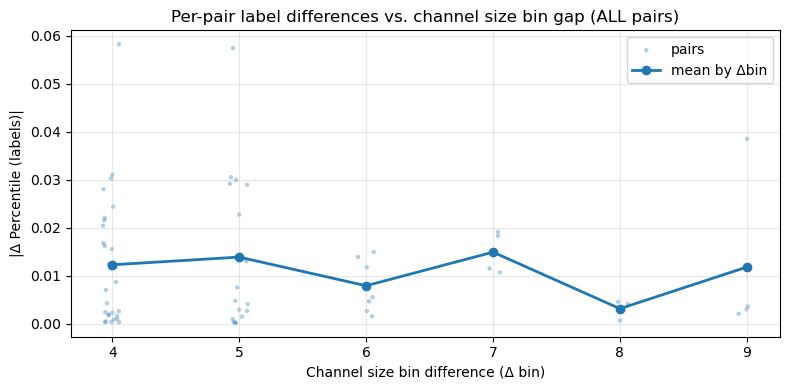

In [ ]:

# plot label differences vs size-bin difference for pairs

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

pairs_df["pctl_diff"] = pairs_df["large_pctl"] - pairs_df["small_pctl"]
pairs_df["pctl_abs_diff"] = pairs_df["pctl_diff"].abs()

x_all = pairs_df["bin_diff"].astype(int).to_numpy()
y_all = pairs_df["pctl_abs_diff"].to_numpy()
x_jit = x_all + (np.random.rand(x_all.shape[0]) - 0.5) * 0.15

plt.figure(figsize=(8,4))
plt.scatter(x_jit, y_all, s=10, alpha=0.35, edgecolors="none", label="pairs")

agg = (pairs_df.groupby("bin_diff", as_index=False)["pctl_abs_diff"]
               .mean()
               .sort_values("bin_diff"))
x_mean = agg["bin_diff"].astype(int).to_numpy()
y_mean = agg["pctl_abs_diff"].to_numpy()

plt.plot(x_mean, y_mean, marker="o", lw=2, label="mean by Δbin", zorder=3)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks(np.sort(np.unique(x_all))) 

plt.xlabel("Channel size bin difference (Δ bin)")
plt.ylabel("|Δ Percentile (labels)|")
plt.title("Per-pair label differences vs. channel size bin gap (ALL pairs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()